In [3]:
## Importing the necessary packages


import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D, Reshape
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal
from keras.regularizers import l2

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cp /content/drive/MyDrive/c247proj/project_data.zip .
!unzip project_data.zip
%cd project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  project_data.zip
replace project/EEG_loading.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/project/._EEG_loading.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace project/X_train_valid.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/project/._X_train_valid.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace project/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content/project


In [6]:
## Loading the dataset

## Loading the numpy arrays

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))



Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [7]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:500]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


In [8]:
# random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = to_categorical(y_test_prep, 4)

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_valid.shape)
print (y_valid.shape)

(6960, 250, 1, 22)
(6960, 4)
(1772, 250, 1, 22)
(1772, 4)
(1500, 250, 1, 22)
(1500, 4)


In [13]:
# Model parameters
dropout = 0.5
learning_rate = 1e-3
epochs = 50
weight_decay = 1e-4

dropouts = [0.4, 0.5, 0.6]
lrs = [1e-3, 1e-4, 3e-4]
wd = [0, 1e-2, 1e-3, 1e-4]

accs = []

for dropout in dropouts:
  for learning_rate in lrs:
    for weight_decay in wd:

      #Building the model

      cnn_model = Sequential()

      # First block of conv.
      cnn_model.add(Conv2D(filters=32, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22)))
      cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Dropout(dropout))

      # Second block of conv.
      cnn_model.add(Conv2D(filters=64, kernel_size=(12,1), padding='same', activation='elu'))
      cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Dropout(dropout))

      # Third block of conv.
      cnn_model.add(Conv2D(filters=128, kernel_size=(12,1), padding='same', activation='elu'))
      cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Dropout(dropout))

      # Fourth block of conv.
      cnn_model.add(Conv2D(filters=256, kernel_size=(12,1), padding='same', activation='elu'))
      cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_model.add(BatchNormalization())
      cnn_model.add(Dropout(dropout))

      # FC layer
      cnn_model.add(Flatten())
      cnn_model.add(Dense(16, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
      cnn_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))

      # Defining the optimizer
      optimizer = keras.optimizers.Adam(lr=learning_rate)

      # Compiling the model
      cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

      # Printing the model summary
      # cnn_model.summary()

      # Training and validating the model

      cnn_results = cnn_model.fit(x_train,
                  y_train,
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=0)

      ## Testing the CNN model

      score = cnn_model.evaluate(x_test, y_test, verbose=0)
      print(f'lr = {learning_rate}, dropout = {dropout}, wd = {weight_decay}, Test accuracy:{score[1]}')
      accs.append(score[1])


print(max(accs))




lr = 0.001, dropout = 0.4, wd = 0, Test accuracy:0.6450338363647461
lr = 0.001, dropout = 0.4, wd = 0.01, Test accuracy:0.703160285949707
lr = 0.001, dropout = 0.4, wd = 0.001, Test accuracy:0.6619638800621033
lr = 0.001, dropout = 0.4, wd = 0.0001, Test accuracy:0.6630925536155701
lr = 0.0001, dropout = 0.4, wd = 0, Test accuracy:0.6540632247924805
lr = 0.0001, dropout = 0.4, wd = 0.01, Test accuracy:0.6591421961784363
lr = 0.0001, dropout = 0.4, wd = 0.001, Test accuracy:0.6461625099182129
lr = 0.0001, dropout = 0.4, wd = 0.0001, Test accuracy:0.6422122120857239
lr = 0.0003, dropout = 0.4, wd = 0, Test accuracy:0.6636568903923035
lr = 0.0003, dropout = 0.4, wd = 0.01, Test accuracy:0.6930022835731506
lr = 0.0003, dropout = 0.4, wd = 0.001, Test accuracy:0.6788939237594604
lr = 0.0003, dropout = 0.4, wd = 0.0001, Test accuracy:0.6721218824386597
lr = 0.001, dropout = 0.5, wd = 0, Test accuracy:0.6817155480384827
lr = 0.001, dropout = 0.5, wd = 0.01, Test accuracy:0.7110609412193298
lr

In [19]:
dropout = 0.6
learning_rate = 1e-3
epochs = 100
weight_decay = 1e-2

cnn_model = Sequential()

# First block of conv.
cnn_model.add(Conv2D(filters=32, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Second block of conv.
cnn_model.add(Conv2D(filters=64, kernel_size=(12,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Third block of conv.
cnn_model.add(Conv2D(filters=128, kernel_size=(12,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# Fourth block of conv.
cnn_model.add(Conv2D(filters=256, kernel_size=(12,1), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(dropout))

# FC layer
cnn_model.add(Flatten())
cnn_model.add(Dense(16, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))
cnn_model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay)))

# Defining the optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

cnn_model.summary()

# Training and validating the model

cnn_results = cnn_model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=1)

## Testing the CNN model

score = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f'lr = {learning_rate}, dropout = {dropout}, wd = {weight_decay}, Test accuracy:{score[1]}')
accs.append(score[1])


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_225 (Conv2D)          (None, 250, 1, 32)        8480      
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 84, 1, 32)         0         
_________________________________________________________________
batch_normalization_173 (Bat (None, 84, 1, 32)         128       
_________________________________________________________________
dropout_173 (Dropout)        (None, 84, 1, 32)         0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 84, 1, 64)         24640     
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 28, 1, 64)         0         
_________________________________________________________________
batch_normalization_174 (Bat (None, 28, 1, 64)       

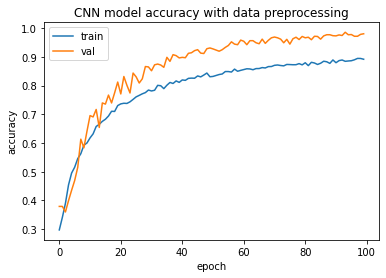

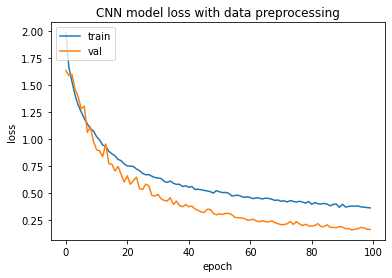

In [21]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('CNN model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()